In [ ]:
!pip install rouge-score

In [ ]:
import numpy as np
import pandas as pd
import json
import os
import re
import gensim
import tensorflow as tf
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords

from tqdm import tqdm
from google.colab import drive
from tensorflow.keras.layers import Concatenate
from tensorflow.keras import backend as K
from tensorflow.keras import Input, Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Layer, TimeDistributed, LSTM, Bidirectional, Dense, Embedding

# from rouge_score import rouge_scorer

from tensorflow.keras.models import model_from_json

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# Using TPU

# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)

# instantiate a distribution strategy
tpu_strategy = tf.distribute.TPUStrategy(tpu)

In [ ]:
# Detect train, dev, and test files
drive.mount('/content/drive')

DATASET_ROOT = '/content/drive/My Drive/indosum'

files_id_dir = os.listdir(DATASET_ROOT)
train_files = []
dev_files = []
test_files = []

for filename in files_id_dir:
    if 'train' in filename:
        train_files.append(filename)
    elif 'dev' in filename:
        dev_files.append(filename)
    elif 'test' in filename:
        test_files.append(filename)

train_files, dev_files, test_files

Mounted at /content/drive


(['train.01.jsonl',
  'train.02.jsonl',
  'train.03.jsonl',
  'train.04.jsonl',
  'train.05.jsonl'],
 ['dev.03.jsonl',
  'dev.02.jsonl',
  'dev.01.jsonl',
  'dev.05.jsonl',
  'dev.04.jsonl'],
 ['test.01.jsonl',
  'test.03.jsonl',
  'test.02.jsonl',
  'test.04.jsonl',
  'test.05.jsonl'])

**<h4>OPENING dan Hanya TESTING/CEK DATA DIAWAL</h4>**

In [ ]:
def load_file_to_json_list(filename):
    file = os.path.join(DATASET_ROOT, filename)
    data = []
    with open(file, 'r') as f:
        json_list = list(f)
        for json_str in tqdm(json_list, desc=f'Loading data {filename}'):
            d = json.loads(json_str)
            data.append(d)
    return data

In [ ]:
jsonl_data = load_file_to_json_list(train_files[0])
len(jsonl_data), jsonl_data[0].keys()

Loading data train.01.jsonl: 100%|██████████| 14262/14262 [00:01<00:00, 7344.36it/s]


(14262,
 dict_keys(['category', 'gold_labels', 'id', 'paragraphs', 'source', 'source_url', 'summary']))

In [ ]:
jsonl_data = load_file_to_json_list(dev_files[0])
len(jsonl_data), jsonl_data[0].keys()

Loading data dev.03.jsonl: 100%|██████████| 747/747 [00:00<00:00, 15376.49it/s]


(747,
 dict_keys(['category', 'gold_labels', 'id', 'paragraphs', 'source', 'source_url', 'summary']))

In [ ]:
jsonl_data = load_file_to_json_list(test_files[0])
len(jsonl_data), jsonl_data[0].keys()

Loading data test.01.jsonl: 100%|██████████| 3762/3762 [00:00<00:00, 8566.18it/s]


(3762,
 dict_keys(['category', 'gold_labels', 'id', 'paragraphs', 'source', 'source_url', 'summary']))

In [ ]:
columns_to_check = ['paragraphs', 'id', 'summary']
for column in columns_to_check:
    column_data = jsonl_data[0][column]
    print(f"{column}: {type(column_data)}")

paragraphs: <class 'list'>
id: <class 'str'>
summary: <class 'list'>


In [ ]:
def paragraph_to_dict_str(paragraph_list):
    paragraph_dict = {} # key = paragraph_id : value = paragraph list
    for i, paragraph in enumerate(paragraph_list):
        new_paragraph = []
        for sentence in paragraph:
            sentence = ' '.join(sentence)
            new_paragraph.append(sentence)
        paragraph_dict[i] = new_paragraph

    json_str = json.dumps(paragraph_dict)
    num = len(paragraph_dict)
    return json_str, num

In [ ]:
# only for testing purpose
paragraph_list = jsonl_data[0]['paragraphs']
paragraph_to_dict_str(paragraph_list)

('{"0": ["Jakarta , CNN Indonesia - - Dilansir AFP , seorang warga Mesir yang dipercaya sebagai wanita terberat di dunia masuk sebuah rumah sakit di Abu Dhabi Kamis ( 5 / 5 ) , dimana ia akan melanjutkan perawatan setelah menjalankan operasi menurunkan badan di India ."], "1": ["Eman Ahmed Abd El Aty memiliki berat badan mencapai 500 kilogram sebelum menjalankan operasi di Mumbai Maret lalu dimana ia mengurangi seperlima dari berat badannya ."], "2": ["Ia menderita berbagai macam masalah kesehatan termasuk penyakit gajah , kondisi yang menyebabkan anggota badan membengkak ."], "3": ["Abd El Aty diberi diet cairan khusus selama berada di India yang bertujuan menurunkan berat badan .", "Diet ini memungkinkan dokter melakukan operasi bariatrik , prosedur bypass yang kini sering dilakukan di India dalam menghadapi masalah obesitas yang bertambah banyak ."], "4": ["Ia tiba di India dengan menggunakan pesawat Airbus yang secara khusus telah dimodifikasi khusus untuk mengangkutnya pada bulan 

In [ ]:
def paragraph_to_text(raw_paragraph_list):
    new_paragraph_list = []
    for i, paragraph in enumerate(raw_paragraph_list):
        paragraph_list = []
        for sentence in paragraph:
            sentence = ' '.join(sentence)
            paragraph_list.append(sentence)

        new_paragraph = ''.join(paragraph_list)
        new_paragraph_list.append(new_paragraph)

    paragraph_str = ''.join(new_paragraph_list)
    return paragraph_str

In [ ]:
pl = jsonl_data[0]['paragraphs']
paragraph_to_text(pl)

'Jakarta , CNN Indonesia - - Dilansir AFP , seorang warga Mesir yang dipercaya sebagai wanita terberat di dunia masuk sebuah rumah sakit di Abu Dhabi Kamis ( 5 / 5 ) , dimana ia akan melanjutkan perawatan setelah menjalankan operasi menurunkan badan di India .Eman Ahmed Abd El Aty memiliki berat badan mencapai 500 kilogram sebelum menjalankan operasi di Mumbai Maret lalu dimana ia mengurangi seperlima dari berat badannya .Ia menderita berbagai macam masalah kesehatan termasuk penyakit gajah , kondisi yang menyebabkan anggota badan membengkak .Abd El Aty diberi diet cairan khusus selama berada di India yang bertujuan menurunkan berat badan .Diet ini memungkinkan dokter melakukan operasi bariatrik , prosedur bypass yang kini sering dilakukan di India dalam menghadapi masalah obesitas yang bertambah banyak .Ia tiba di India dengan menggunakan pesawat Airbus yang secara khusus telah dimodifikasi khusus untuk mengangkutnya pada bulan Februari .Kini , berat badannya telah turun drastis seban

In [ ]:
def id_to_text(raw_paragraph):
    words = raw_paragraph.split()
    formatted_text = '-'.join(words)
    return formatted_text

In [ ]:
il = jsonl_data[0]['id']
id_to_text(il)

'1494135000-wanita-terberat-di-dunia-jalani-fisioterapi'

In [ ]:
def summary_to_text(raw_summary_list):
    summary_list = []
    for i, summary in enumerate(raw_summary_list):
        summary_list.append(' '.join(summary))

    summary_str = ''.join(summary_list)
    return summary_str

In [ ]:
sl = jsonl_data[0]['summary']
summary_to_text(sl)

'Eman Ahmed Abd El Aty memiliki berat badan mencapai 500 kilogram sebelum menjalankan operasi di Mumbai Maret lalu dimana ia mengurangi seperlima dari berat badannya .Abd El Aty diberi diet cairan khusus selama berada di India yang bertujuan menurunkan berat badan .Kini , berat badannya telah turun drastis sebanyak 323 kilogram dalam tiga bulan .Sekarang berat badannya tinggal 176,6 kilogram .'

In [ ]:
columns_to_check = ['paragraphs', 'id', 'summary']
for column in columns_to_check:
    column_data = jsonl_data[0][column]
    print(f"{column}: {type(column_data)}")

paragraphs: <class 'list'>
id: <class 'str'>
summary: <class 'list'>


**<h4>Mengaplikasikan fungsi2 diatas</h4>**

In [ ]:
def alter_json_data(json_list_data, filename=''):
    new_json_list = []
    for jsonl_data in tqdm(json_list_data, desc=f'Altering json data {filename}'):
        jsonl_data['paragraphs'] = paragraph_to_text(jsonl_data['paragraphs'])
        #jsonl_data['id'] = id_to_text(jsonl_data['id'])
        jsonl_data['summary'] = summary_to_text(jsonl_data['summary'])

        new_json_list.append(jsonl_data)

    return new_json_list

In [ ]:
alter_json_data(jsonl_data)
print('hasil konversi teks berita: \n', jsonl_data[0]['paragraphs'], '\n')
print('hasil konversi ringkasan manual: \n',jsonl_data[0]['summary'])

Altering json data : 100%|██████████| 3762/3762 [00:00<00:00, 47761.80it/s]

hasil konversi teks berita: 
 Jakarta , CNN Indonesia - - Dilansir AFP , seorang warga Mesir yang dipercaya sebagai wanita terberat di dunia masuk sebuah rumah sakit di Abu Dhabi Kamis ( 5 / 5 ) , dimana ia akan melanjutkan perawatan setelah menjalankan operasi menurunkan badan di India .Eman Ahmed Abd El Aty memiliki berat badan mencapai 500 kilogram sebelum menjalankan operasi di Mumbai Maret lalu dimana ia mengurangi seperlima dari berat badannya .Ia menderita berbagai macam masalah kesehatan termasuk penyakit gajah , kondisi yang menyebabkan anggota badan membengkak .Abd El Aty diberi diet cairan khusus selama berada di India yang bertujuan menurunkan berat badan .Diet ini memungkinkan dokter melakukan operasi bariatrik , prosedur bypass yang kini sering dilakukan di India dalam menghadapi masalah obesitas yang bertambah banyak .Ia tiba di India dengan menggunakan pesawat Airbus yang secara khusus telah dimodifikasi khusus untuk mengangkutnya pada bulan Februari .Kini , berat badan

In [ ]:
columns_to_check = ['paragraphs', 'id', 'summary']
for column in columns_to_check:
    column_data = jsonl_data[0][column]
    print(f"{column}: {type(column_data)}")

paragraphs: <class 'str'>
id: <class 'str'>
summary: <class 'str'>


<h4>Membuat dataframe untuk tiap file (training, testing, validation)</h4>

In [ ]:
def create_dataset(jsonl):
    header = list(jsonl[0].keys())
    dataset_list = []
    for json_data in jsonl:
        row = []
        for h in header:
            row.append(json_data[h])
        dataset_list.append(row)

    return header, dataset_list

In [ ]:
def load_file_to_json_list(filename):
    file = os.path.join(DATASET_ROOT, filename)
    data = []
    with open(file, 'r') as f:
        json_list = list(f)
        for json_str in tqdm(json_list, desc=f'Loading data {filename}'):
            d = json.loads(json_str)
            data.append(d)
    return data

In [ ]:
def create_dataset_from_files(file_list):
    df_header = None
    dataset_list = []
    for filename in file_list:
        json_l = load_file_to_json_list(filename)
        new_json_l = alter_json_data(json_l, filename)
        header, dataset_part = create_dataset(new_json_l)

        if not df_header: df_header = header
        dataset_list.extend(dataset_part)

    df_full = pd.DataFrame().from_records(dataset_list)
    df_full = df_full.rename(columns=dict(enumerate(header)))
    return df_full

In [ ]:
def filter_columns(dataframe):
    # Memilih kolom yang ingin dipertahankan
    selected_columns = ['id', 'paragraphs', 'summary']

    # Menghapus kolom yang tidak termasuk dalam selected_columns
    filtered_dataframe = dataframe[selected_columns]

    return filtered_dataframe

In [ ]:
train_files = ["train.01.jsonl"]
dev_files = ["dev.01.jsonl"]
test_files = ["test.01.jsonl"]

In [ ]:
df_train = create_dataset_from_files(train_files)
df_dev = create_dataset_from_files(dev_files)
df_test = create_dataset_from_files(test_files)

Altering json data test.01.jsonl: 100%|██████████| 3762/3762 [00:00<00:00, 44849.94it/s]


In [ ]:
df_train = filter_columns(df_train)
df_dev = filter_columns(df_dev)
df_test = filter_columns(df_test)

In [ ]:
df_train.sample(5)

,id,paragraphs,summary
12154,1508346900-anies-baswedan-resmi-dipolisikan-te...,"Jakarta , CNN Indonesia - - Gubernur DKI Jakar...",Gubernur DKI Jakarta Anies Baswedan resmi dila...
7857,1509687000-convert-gambar-dan-dokumen-ke-pdf-d...,"Pada umumnya , untuk melakukan konversi gambar...",Anda dapat mengubah dokumen ke format PDF...
1482,1503268664-puan-minta-buku-sea-games-yang-muat...,Sikap tegas ditunjukkan pemerintah Indonesia t...,Sikap tegas ditunjukkan pemerintah Indonesia t...
6172,1478991626-nissan-luncurkan-juke-black-pearl-e...,Suara.com - Nissan pada Kamis ( 10 / 11 / 2016...,Nissan telah memperkenalkan Nissan Juke Black ...
8242,1511892000-32-tim-berebut-jadi-terbaik-di-keju...,BOLASPORT.COM – Kejuaraan Nasional ( Kejurnas ...,Kejurnas yang diikuti 16 tim putra dan 16 tim ...


In [ ]:
print(len(df_train))
print(len(df_dev))
print(len(df_test))

14262
750
3762


**PREPROCESSING**

In [ ]:
def rm_stopwords_from_text(text):
    stop_words = stopwords.words('indonesian')
    text = text.split()
    word_list = [word for word in text if word not in stop_words]
    return ' '.join(word_list)

In [ ]:
def preprocess_text(text):
    #text = rm_stopwords_from_text(text)
    if isinstance(text, list):
        # If text is a list, join its elements into a single string
        text = ' '.join(text)
        return text

    # Then, perform lowercasing
    text = text.lower()

    text = re.sub(r'\d', '', text)

    text = text.replace('-', ' ')
    text = text.replace('–', ' ')
    text = re.sub(r'[()/\"“”;:$%&*@#!?.,]', '', text)
    text = re.sub(r'\s+', ' ', text)

    text = re.sub(r'\s+([.,])', r'\1', text)

    text = re.sub(r'\.(\S)', r'. \1', text)

    text = text.strip()

    return text

In [ ]:
dataframes_to_preprocess = [df_train, df_dev, df_test]
for df in dataframes_to_preprocess:
    df['man_summary'] = df['id'] + ' ' + df['summary']

    df.drop(['id', 'summary'], axis=1, inplace=True)

In [ ]:
for df in dataframes_to_preprocess:
    df['man_summary'] = df.apply(lambda row: preprocess_text(row['man_summary']), axis=1)

    df['paragraphs'] = df.apply(lambda row: preprocess_text(row['paragraphs']), axis=1)

In [ ]:
preprocess_text(df_train.iloc[2]['man_summary'])

'songsong visit bengkulu perkuat sdm pariwisat dinas pariwisata provinsi bengkulu kembali menggelar kegiatan bimbingan teknis bimtek sdm kepariwisataan dalam menyongson visit wonderful bengkulu pada november yang lalu kegiatan yang berlangsung pada hingga november kemarin tersebut sebagai bagian dari upaya pemerintah provinsi bengkulu dalam memperkuat sdm pariwisata untuk menyongsong visit wonderful bengkulu'

In [ ]:
df_train.iloc[2]['man_summary']

'songsong visit bengkulu perkuat sdm pariwisat dinas pariwisata provinsi bengkulu kembali menggelar kegiatan bimbingan teknis bimtek sdm kepariwisataan dalam menyongson visit wonderful bengkulu pada november yang lalu kegiatan yang berlangsung pada hingga november kemarin tersebut sebagai bagian dari upaya pemerintah provinsi bengkulu dalam memperkuat sdm pariwisata untuk menyongsong visit wonderful bengkulu'

In [ ]:
df_train.isna().sum()

paragraphs     0
man_summary    0
dtype: int64

In [ ]:
df_dev.isna().sum()

paragraphs     0
man_summary    0
dtype: int64

In [ ]:
df_test.isna().sum()

paragraphs     0
man_summary    0
dtype: int64

In [ ]:
df_train.man_summary = df_train.man_summary.apply(lambda x: f'_START_ {x} _END_')
df_dev.man_summary = df_dev.man_summary.apply(lambda x: f'_START_ {x} _END_')
df_test.man_summary = df_test.man_summary.apply(lambda x: f'_START_ {x} _END_')

In [ ]:
start_token = 'sostok'
end_token = 'eostok'

df_train['man_summary'] = df_train['man_summary'].apply(lambda x: f'{start_token} {x} {end_token}')

df_dev['man_summary'] = df_dev['man_summary'].apply(lambda x: f'{start_token} {x} {end_token}')

df_test['man_summary'] = df_test['man_summary'].apply(lambda x: f'{start_token} {x} {end_token}')

In [ ]:
df_dev.iloc[0]['man_summary']

'sostok _START_ mustahil transportasi tradisional dan online bersa ketua mpr zulkifli hasan menyesalkan kisruh yang terjadi antara pelaku sarana transportasi online dan tradisional zulkifli menyarankan adanya pertemuan bersama antara pemerintah pelaku transportasi online dan transportasi tradisional demi meredam kisruh yang masih belum terselesaikan zulkifli menilai aturan yang dikeluarkan pemerintah seharusnya tidak hanya membahas tarif tapi juga mekanisme yang dapat menguntungkan semua pihak baik pelaku transportasi online maupun tradisional _END_ eostok'

**<h4>TOKENIZING DAN VEKTORISASI</h4>**

**<h4>TOKENISASI</h4>**

In [ ]:
max_len_paragraphs = max([len(text.split()) for text in df_train['paragraphs']] +
                   [len(text.split()) for text in df_dev['paragraphs']] +
                   [len(text.split()) for text in df_test['paragraphs']])

max_len_summary = max([len(text.split()) for text in df_train['man_summary']] +
                       [len(text.split()) for text in df_dev['man_summary']] +
                       [len(text.split()) for text in df_test['man_summary']])

print(max_len_paragraphs, max_len_summary)

1235 98


In [ ]:
# Data Training
x_train = df_train['paragraphs']
y_train = df_train['man_summary']

# Data test
x_val = df_test['paragraphs']
y_val = df_test['man_summary']

In [ ]:
# Tokenizer for paragraphs
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_train))

In [ ]:
x_train_sequence = x_tokenizer.texts_to_sequences(x_train)
x_val_sequence = x_tokenizer.texts_to_sequences(x_val)

x_train_pad = pad_sequences(x_train_sequence, maxlen=max_len_paragraphs, padding='post')
x_val_pad = pad_sequences(x_val_sequence, maxlen=max_len_paragraphs, padding='post')

x_vocab_size = len(x_tokenizer.word_index) + 1

# x_vocab_size = x_tokenizer.num_words + 1

print(x_vocab_size)

95481


In [ ]:
# Tokenizer for summary
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_train))

In [ ]:
y_train_sequence = y_tokenizer.texts_to_sequences(y_train)
y_val_sequence = y_tokenizer.texts_to_sequences(y_val)

y_train_pad = pad_sequences(y_train_sequence, maxlen=max_len_summary, padding='post')
y_val_pad = pad_sequences(y_val_sequence, maxlen=max_len_summary, padding='post')

y_vocab_size = len(y_tokenizer.word_index) + 1

# y_vocab_size = y_tokenizer.num_words + 1

print(y_vocab_size)

45919


In [ ]:
"""
# Tokenizer for paragraphs
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_train))
x_train_seq = x_tokenizer.texts_to_sequences(x_train)
x_dev_seq = x_tokenizer.texts_to_sequences(x_dev)
x_train_pad = pad_sequences(x_train_seq, maxlen=max_len_paragraphs, padding='post')
x_dev_pad = pad_sequences(x_dev_seq, maxlen=max_len_paragraphs, padding='post')
#Vocab size of paragraphs.
x_vocab_size = len(x_tokenizer.word_index) + 1
print(x_vocab_size)

# Tokenizer for summary
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_train))
y_train_seq =y_tokenizer.texts_to_sequences(y_train)
y_dev_seq = y_tokenizer.texts_to_sequences(y_dev)
y_train_pad = pad_sequences(y_train_seq, maxlen=max_len_summary, padding='post')
y_dev_pad = pad_sequences(y_dev_seq, maxlen=max_len_summary, padding='post')
#Vocab size of summaries.
y_vocab_size = len(y_tokenizer.word_index) + 1
print(y_vocab_size)
"""

"\n# Tokenizer for paragraphs\nx_tokenizer = Tokenizer()\nx_tokenizer.fit_on_texts(list(x_train))\nx_train_seq = x_tokenizer.texts_to_sequences(x_train)\nx_dev_seq = x_tokenizer.texts_to_sequences(x_dev)\nx_train_pad = pad_sequences(x_train_seq, maxlen=max_len_paragraphs, padding='post')\nx_dev_pad = pad_sequences(x_dev_seq, maxlen=max_len_paragraphs, padding='post')\n#Vocab size of paragraphs.\nx_vocab_size = len(x_tokenizer.word_index) + 1\nprint(x_vocab_size)\n\n# Tokenizer for summary\ny_tokenizer = Tokenizer()\ny_tokenizer.fit_on_texts(list(y_train))\ny_train_seq =y_tokenizer.texts_to_sequences(y_train)\ny_dev_seq = y_tokenizer.texts_to_sequences(y_dev)\ny_train_pad = pad_sequences(y_train_seq, maxlen=max_len_summary, padding='post')\ny_dev_pad = pad_sequences(y_dev_seq, maxlen=max_len_summary, padding='post')\n#Vocab size of summaries.\ny_vocab_size = len(y_tokenizer.word_index) + 1\nprint(y_vocab_size)\n"

In [ ]:
def remove_indexes(summary_array):
    remove_indexes = []
    for i in range(len(summary_array)):
        count = 0
        for j in summary_array[i]:
            if j != 0:
                count += 1
        if count == 2:
            remove_indexes.append(i)
    return remove_indexes


remove_train_indexes = remove_indexes(y_train_pad)
remove_val_indexes = remove_indexes(y_val_pad)

y_train_pad = np.delete(y_train_pad, remove_train_indexes, axis=0)
x_train_pad = np.delete(x_train_pad, remove_train_indexes, axis=0)

y_val_pad = np.delete(y_val_pad, remove_val_indexes, axis=0)
x_val_pad = np.delete(x_val_pad, remove_val_indexes, axis=0)

<h4>ATTENTION LAYER</h4>


source : https://github.com/thushv89/attention_keras/blob/master/src/layers/attention.py

In [ ]:
class AttentionLayer(Layer):
    """
    This class implements Bahdanau att
    ention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state """

            assert_msg = "States must be a list. However states {} is of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch_size*en_seq_len, latent_dim
            reshaped_enc_outputs = K.reshape(encoder_out_seq, (-1, en_hidden))
            # <= batch_size*en_seq_len, latent_dim
            W_a_dot_s = K.reshape(K.dot(reshaped_enc_outputs, self.W_a), (-1, en_seq_len, en_hidden))
            if verbose:
                print('wa.s>',W_a_dot_s.shape)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>',U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            reshaped_Ws_plus_Uh = K.tanh(K.reshape(W_a_dot_s + U_a_dot_h, (-1, en_hidden)))
            if verbose:
                print('Ws+Uh>', reshaped_Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.reshape(K.dot(reshaped_Ws_plus_Uh, self.V_a), (-1, en_seq_len))
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """
            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        def create_inital_state(inputs, hidden_size):
            # We are not using initial states, but need to pass something to K.rnn funciton
            fake_state = K.zeros_like(inputs)  # <= (batch_size, enc_seq_len, latent_dim
            fake_state = K.sum(fake_state, axis=[1, 2])  # <= (batch_size)
            fake_state = K.expand_dims(fake_state)  # <= (batch_size, 1)
            fake_state = K.tile(fake_state, [1, hidden_size])  # <= (batch_size, latent_dim
            return fake_state

        fake_state_c = create_inital_state(encoder_out_seq, encoder_out_seq.shape[-1])
        fake_state_e = create_inital_state(encoder_out_seq, encoder_out_seq.shape[1])  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

**<h4>VEKTORISASI</h4>**

In [ ]:
latent_dim = 64
embedding_dim = 300
num_epochs = 40

In [ ]:
def load_word2vec_model(path):
    return gensim.models.Word2Vec.load(path)

def get_embedding_matrix_from_word2vec(tokenizer, word2vec_model, embedding_dim, vocab_size=None):
    word_index = tokenizer.word_index
    voc = list(word_index.keys())

    print("Found %s word vectors." % len(word2vec_model.wv))

    num_tokens = len(voc) + 2 if not vocab_size else vocab_size
    hits = 0
    misses = 0

    embedding_matrix = np.zeros((num_tokens, embedding_dim))
    for word, i in word_index.items():
        try:
            embedding_vector = word2vec_model.wv[word]
        except KeyError:
            embedding_vector = None

        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
            hits += 1
        else:
            misses += 1
    print("Converted %d words (%d misses)" % (hits, misses))

    return embedding_matrix

word2vec_path = '/content/drive/My Drive/word2vec/idwiki_word2vec_300.model'
word2vec_model = load_word2vec_model(word2vec_path)

x_embedding_matrix = get_embedding_matrix_from_word2vec(x_tokenizer, word2vec_model, embedding_dim, x_vocab_size)
y_embedding_matrix = get_embedding_matrix_from_word2vec(y_tokenizer, word2vec_model, embedding_dim, y_vocab_size)

Found 331792 word vectors.
Converted 63913 words (31567 misses)
Found 331792 word vectors.
Converted 37619 words (8299 misses)


In [ ]:
print(x_embedding_matrix.shape)
print(y_embedding_matrix.shape)

(95481, 300)
(45919, 300)


**<h4>TRAINING MODEL WITH SEQ2SEQ MODEL DAN BILSTM</h4>**

In [ ]:
def build_seq2seq_model_with_bidirectional_lstm(
    embedding_dim, latent_dim, max_len_paragraphs,
    x_vocab_size, y_vocab_size,
    x_embedding_matrix, y_embedding_matrix
):
    # instantiating the model in the strategy scope creates the model on the TPU
    with tpu_strategy.scope():

        # =====================
        # 🔥 Encoder
        # =====================
        encoder_input = Input(shape=(max_len_paragraphs, ))

        # encoder embedding layer
        encoder_embedding = Embedding(
            x_vocab_size,
            embedding_dim,
            embeddings_initializer=tf.keras.initializers.Constant(x_embedding_matrix),
            trainable=False,
            name='encoder_embedding'
        )(encoder_input)

        # encoder lstm1
        encoder_bi_lstm1 = Bidirectional(
            LSTM(
                latent_dim,
                return_sequences=True,
                return_state=True,
                dropout=0.4,
                recurrent_dropout=0.4,
                name='encoder_lstm_1'
            ),
            name='encoder_bidirectional_lstm_1'
        )
        encoder_output1, forward_h1, forward_c1, backward_h1, backward_c1 = encoder_bi_lstm1(
            encoder_embedding
        )
        encoder_bi_lstm1_output = [
            encoder_output1, forward_h1, forward_c1, backward_h1, backward_c1
        ]

        # encoder lstm 2
        encoder_bi_lstm2 = Bidirectional(
            LSTM(
                latent_dim,
                return_sequences=True,
                return_state=True,
                dropout=0.4,
                recurrent_dropout=0.4,
                name='encoder_lstm_2'
            ),
            name='encoder_bidirectional_lstm_2'
        )
        encoder_output2, forward_h2, forward_c2, backward_h2, backward_c2 = encoder_bi_lstm2(
            encoder_output1
        )
        encoder_bi_lstm2_output = [
            encoder_output2, forward_h2, forward_c2, backward_h2, backward_c2
        ]

        # encoder lstm 3
        encoder_bi_lstm = Bidirectional(
            LSTM(
                latent_dim,
                return_sequences=True,
                return_state=True,
                dropout=0.4,
                recurrent_dropout=0.4,
                name='encoder_lstm_3'
            ),
            name='encoder_bidirectional_lstm_3'
        )
        encoder_output, *encoder_final_states = encoder_bi_lstm(encoder_output2)

        # =====================
        # 🌈 Decoder
        # =====================

        # Set up the decoder, using `encoder_states` as initial state.

        decoder_input = Input(shape=(None, ))

        # decoder embedding layer
        decoder_embedding_layer = Embedding(
            y_vocab_size,
            embedding_dim,
            embeddings_initializer=tf.keras.initializers.Constant(y_embedding_matrix),
            trainable=False,
            name='decoder_embedding'
        )
        decoder_embedding = decoder_embedding_layer(decoder_input)

        decoder_bi_lstm = Bidirectional(
            LSTM(
                latent_dim,
                return_sequences=True,
                return_state=True,
                dropout=0.4,
                recurrent_dropout=0.2,
                name='decoder_lstm_1'
            ),
            name='decoder_bidirectional_lstm_1'
        )
        decoder_output, *decoder_final_states = decoder_bi_lstm(
            decoder_embedding, initial_state=encoder_final_states
            # decoder_embedding, initial_state=encoder_final_states[:2]
        )  # taking only the forward states

        attn_layer = AttentionLayer(name='attention_layer')
        attn_out, attn_states = attn_layer([encoder_output, decoder_output])

        # dense layer
        decoder_dense = TimeDistributed(
            Dense(y_vocab_size, activation='softmax')
        )
        decoder_output = decoder_dense(decoder_output)

        # =====================
        # ⚡️ Model
        # =====================
        model = Model([encoder_input, decoder_input], decoder_output, name='seq2seq_model_with_bidirectional_lstm')
        model.summary()

        optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
        model.compile(
            optimizer=optimizer,
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        return {
            'model': model,
            'inputs': {
                'encoder': encoder_input,
                'decoder': decoder_input
            },
            'outputs': {
                'encoder': encoder_output,
                'decoder': decoder_output
            },
            'states': {
                'encoder': encoder_final_states,
                'decoder': decoder_final_states
            },
            'layers': {
                'decoder': {
                    'embedding': decoder_embedding_layer,
                    'attention': attn_layer,
                    'last_decoder_lstm': decoder_bi_lstm,
                    'dense': decoder_dense
                }
            }
        }

In [ ]:
seq2seq = build_seq2seq_model_with_bidirectional_lstm(
    embedding_dim, latent_dim, max_len_paragraphs,
    x_vocab_size, y_vocab_size,
    x_embedding_matrix, y_embedding_matrix
)

Model: "seq2seq_model_with_bidirectional_lstm"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1235)]               0         []                            
                                                                                                  
 encoder_embedding (Embeddi  (None, 1235, 300)            2864430   ['input_1[0][0]']             
 ng)                                                      0                                       
                                                                                                  
 encoder_bidirectional_lstm  [(None, 1235, 128),          186880    ['encoder_embedding[0][0]']   
 _1 (Bidirectional)           (None, 64),                                                         
                              (None, 64),                     

In [ ]:
model = seq2seq['model']

encoder_input = seq2seq['inputs']['encoder']
decoder_input = seq2seq['inputs']['decoder']

encoder_output = seq2seq['outputs']['encoder']
decoder_output = seq2seq['outputs']['decoder']

encoder_final_states = seq2seq['states']['encoder']
decoder_final_states = seq2seq['states']['decoder']

decoder_embedding_layer = seq2seq['layers']['decoder']['embedding']
last_decoder_lstm = seq2seq['layers']['decoder']['last_decoder_lstm']
decoder_dense = seq2seq['layers']['decoder']['dense']


In [ ]:
model.layers[-2].input

[<KerasTensor: shape=(None, None, 300) dtype=float32 (created by layer 'decoder_embedding')>,
 <KerasTensor: shape=(None, 64) dtype=float32 (created by layer 'encoder_bidirectional_lstm_3')>,
 <KerasTensor: shape=(None, 64) dtype=float32 (created by layer 'encoder_bidirectional_lstm_3')>,
 <KerasTensor: shape=(None, 64) dtype=float32 (created by layer 'encoder_bidirectional_lstm_3')>,
 <KerasTensor: shape=(None, 64) dtype=float32 (created by layer 'encoder_bidirectional_lstm_3')>]

In [ ]:
callbacks = [
  EarlyStopping(
    monitor='accuracy',  # Memantau metrik akurasi pada data validasi
    mode='max',               # Mode 'max' karena ingin mendapatkan akurasi maksimum
    verbose=1,                # Menampilkan pesan verbose
    patience=2,                # Bersabar selama 2 epoch jika akurasi tidak meningkat
    baseline=0.95,            # Menentukan baseline akurasi yang diharapkan
  ),

  # Membuat callback ReduceLROnPlateau seperti yang telah Anda tentukan
  ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=2,
    min_lr=0.000001,
    verbose=1,
  )
]

In [ ]:
history = model.fit(
    [x_train_pad, y_train_pad[:, :-1]],
    y_train_pad.reshape(y_train_pad.shape[0], y_train_pad.shape[1], 1)[:, 1:],
    epochs=num_epochs,
    batch_size=128,
    #callbacks=[callback],
    validation_data=(
        [x_val_pad, y_val_pad[:, :-1]],
        y_val_pad.reshape(y_val_pad.shape[0], y_val_pad.shape[1], 1)[:, 1:]
    )
)

Epoch 1/40
112/112 [==============================] - 259s 2s/step - loss: 6.9727 - accuracy: 0.3418 - val_loss: 5.0598 - val_accuracy: 0.3882
Epoch 2/40
112/112 [==============================] - 169s 2s/step - loss: 5.0535 - accuracy: 0.3774 - val_loss: 4.5164 - val_accuracy: 0.4146
Epoch 3/40
112/112 [==============================] - 169s 2s/step - loss: 4.5123 - accuracy: 0.4160 - val_loss: 3.9786 - val_accuracy: 0.4630
Epoch 4/40
112/112 [==============================] - 169s 2s/step - loss: 4.0278 - accuracy: 0.4622 - val_loss: 3.5385 - val_accuracy: 0.5112
Epoch 5/40
112/112 [==============================] - 169s 2s/step - loss: 3.6415 - accuracy: 0.5030 - val_loss: 3.1866 - val_accuracy: 0.5518
Epoch 6/40
112/112 [==============================] - 169s 2s/step - loss: 3.3311 - accuracy: 0.5366 - val_loss: 2.9007 - val_accuracy: 0.5862
Epoch 7/40
112/112 [==============================] - 169s 2s/step - loss: 3.0733 - accuracy: 0.5646 - val_loss: 2.6567 - val_accuracy: 0.6164

notes:
1. layer 128, overfit
2. layer 64, harus banyak epoch
3. lesgoo

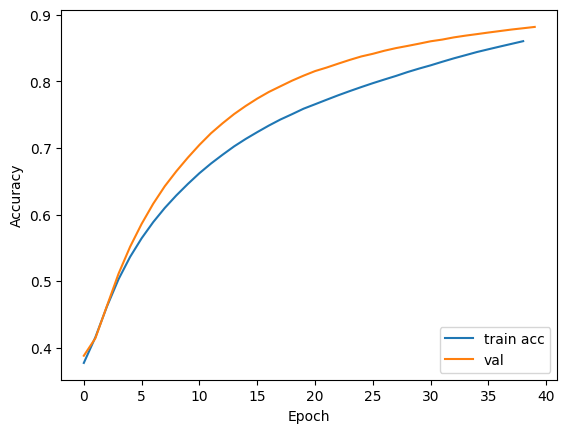

In [ ]:
# Accuracy
plt.plot(history.history['accuracy'][1:], label='train acc')
plt.plot(history.history['val_accuracy'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

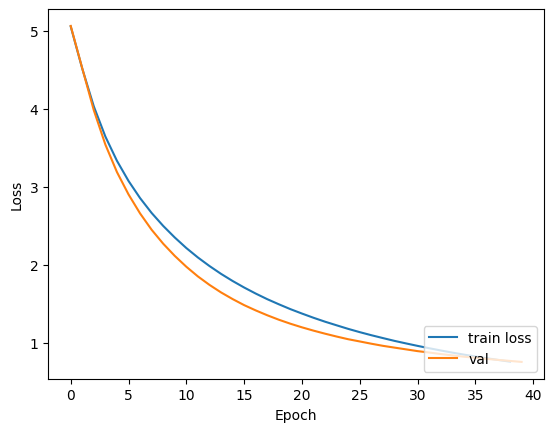

In [ ]:
# Loss
plt.plot(history.history['loss'][1:], label='train loss')
plt.plot(history.history['val_loss'], label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='lower right')

In [ ]:
# Next, let’s build the dictionary to convert the index to word for target and source vocabulary:
reverse_target_word_index = y_tokenizer.index_word
reverse_source_word_index = x_tokenizer.index_word
target_word_index = y_tokenizer.word_index

In [ ]:
def build_seq2seq_model_with_bidirectional_lstm_inference(
    max_len_paragraphs, latent_dim, encoder_input, encoder_output,
    encoder_final_states, decoder_input, decoder_output,
    decoder_embedding_layer, decoder_dense, last_decoder_bi_lstm
):
    # Encode the input sequence to get the feature vector
    encoder_model = Model(
        inputs=encoder_input, outputs=[encoder_output] + encoder_final_states
    )

    # Decoder setup
    # Below tensors will hold the states of the previous time step
    decoder_state_forward_input_h = Input(shape=(latent_dim, ))
    decoder_state_forward_input_c = Input(shape=(latent_dim, ))
    decoder_state_backward_input_h = Input(shape=(latent_dim, ))
    decoder_state_backward_input_c = Input(shape=(latent_dim, ))

    # Create the hidden input layer with twice the latent dimension,
    # since we are using bi - directional LSTM's we will get
    # two hidden states and two cell states
    decoder_hidden_state_input = Input(shape=(max_len_paragraphs, latent_dim * 2))

    decoder_initial_state = [
        decoder_state_forward_input_h, decoder_state_forward_input_c,
        decoder_state_backward_input_h, decoder_state_backward_input_c
    ]

    # Get the embeddings of the decoder sequence
    decoder_embedding = decoder_embedding_layer(decoder_input)

    # To predict the next word in the sequence, set the initial
    # states to the states from the previous time step
    decoder_output, *decoder_states = last_decoder_bi_lstm(
        decoder_embedding, initial_state=decoder_initial_state
    )

    # A dense softmax layer to generate prob dist. over the target vocabulary
    decoder_output = decoder_dense(decoder_output)

    # Final decoder model
    decoder_model = Model(
        [decoder_input] + [decoder_hidden_state_input] + decoder_initial_state,
        [decoder_output] + decoder_states
    )

    return (encoder_model, decoder_model)

In [ ]:
encoder_model, decoder_model = build_seq2seq_model_with_bidirectional_lstm_inference(
    max_len_paragraphs, latent_dim, encoder_input, encoder_output,
    encoder_final_states, decoder_input, decoder_output,
    decoder_embedding_layer, decoder_dense, last_decoder_lstm
)

In [ ]:
encoder_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1235)]            0         
                                                                 
 encoder_embedding (Embeddi  (None, 1235, 300)         28644300  
 ng)                                                             
                                                                 
 encoder_bidirectional_lstm  [(None, 1235, 128),       186880    
 _1 (Bidirectional)           (None, 64),                        
                              (None, 64),                        
                              (None, 64),                        
                              (None, 64)]                        
                                                                 
 encoder_bidirectional_lstm  [(None, 1235, 128),       98816     
 _2 (Bidirectional)           (None, 64),                    

In [ ]:
decoder_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 decoder_embedding (Embeddi  (None, None, 300)            1377570   ['input_2[0][0]']             
 ng)                                                      0                                       
                                                                                                  
 input_3 (InputLayer)        [(None, 64)]                 0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 64)]                 0         []                      

In [ ]:
decoder_model.layers[-3].input

[<KerasTensor: shape=(None, None, 300) dtype=float32 (created by layer 'decoder_embedding')>,
 <KerasTensor: shape=(None, 64) dtype=float32 (created by layer 'encoder_bidirectional_lstm_3')>,
 <KerasTensor: shape=(None, 64) dtype=float32 (created by layer 'encoder_bidirectional_lstm_3')>,
 <KerasTensor: shape=(None, 64) dtype=float32 (created by layer 'encoder_bidirectional_lstm_3')>,
 <KerasTensor: shape=(None, 64) dtype=float32 (created by layer 'encoder_bidirectional_lstm_3')>]

In [ ]:
def decode_sequence_seq2seq_model_with_bidirectional_lstm(
    input_sequence, encoder_model, decoder_model
):
    # Encode the input as state vectors.
    e_out, *state_values = encoder_model.predict(input_sequence)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1))

    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index[start_token]

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        output_tokens, *decoder_states = decoder_model.predict(
            [target_seq] + [e_out] + state_values
        )

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :]) # Greedy Search
        sampled_token = reverse_target_word_index[sampled_token_index + 1]

        if sampled_token != end_token:
            decoded_sentence += ' ' + sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == end_token) or (len(decoded_sentence.split()) >= (max_len_summary - 1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        state_values = decoder_states

    return decoded_sentence

In [ ]:
def seq2summary(input_sequence):
    new_string = ''
    for i in input_sequence:
        if i != 0:  # Assuming 0 is not part of your actual vocabulary
            new_string = new_string + reverse_target_word_index[i] + ' '
    return new_string

In [ ]:
def seq2text(input_sequence):
    new_string = ''
    for i in input_sequence:
        if i != 0:
            new_string = new_string + reverse_source_word_index[i] + ' '
    return new_string

In [ ]:
l = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

if len(l) % 3 != 0:
    while len(l) % 3 != 0:
        l.append(0)
print(l)

lst_i = 3
for i in range(0, len(l), 3):
    print(l[i:i + lst_i])

print(' '.join(['', 'james', 'ethan', '', 'tony']))
print(' '.join(' '.join(['', 'james', 'ethan', '', 'tony']).split()))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 0, 0]
[1, 2, 3]
[4, 5, 6]
[7, 8, 9]
[10, 0, 0]
 james ethan  tony
james ethan tony


In [ ]:
def predict_text(text, decode_sequence, encoder_model, decoder_model):
    original_text = text
    text = preprocess_text([text])  # generator
    text_list = original_text.split()

    if len(text_list) <= max_len_paragraphs:
        #text = expand_contractions(text)
        text = preprocess_text(text)
        #text = f'_START_ {text} _END_'
        text = f'{start_token} {text} {end_token}'

        seq = x_tokenizer.texts_to_sequences([' '.join(text_list)])
        padded = pad_sequences(seq, maxlen=max_len_paragraphs, padding='post')
        pred_summary = decode_sequence(
            padded.reshape(1, max_len_paragraphs), encoder_model, decoder_model
        )
        return pred_summary
    else:
        pred_summary = ''

        # breaking long texts to individual max_len_paragraphs texts and predicting on them
        while len(text_list) % max_len_paragraphs== 0:
            text_list.append('')

        lst_i = max_len_paragraphs
        for i in range(0, len(text_list), max_len_paragraphs):
            _text_list = original_text.split()[i:i + lst_i]
            _text = ' '.join(_text_list)
            _text = ' '.join(
                _text.split()
            )  # to remove spaces that were added to make len(text_list) % max_len_paragraphs == 0

            #_text = expand_contractions(_text)
            _text = preprocess_text(_text)  # generator
            _text = f'_START_ {_text} _END_'
            _text = f'{start_token} {_text} {end_token}'
            # print(_text, '\n')

            _seq = x_tokenizer.texts_to_sequences([_text])
            _padded = pad_sequences(_seq, maxlen=max_len_paragraphs, padding='post')
            _pred = decode_sequence(
                _padded.reshape(1, max_len_paragraphs), encoder_model, decoder_model
            )
            pred_summary += ' ' + ' '.join(_pred.split()[1:-2])
            pred_summary = ' '.join(pred_summary.split())

        return pred_summary

In [ ]:
# Testing on training data
for i in range(2, 3):
    print(f"# {i+1} News: ", seq2text(x_train_pad[i]))
    print("Original summary: ", seq2summary(y_train_pad[i]))
    print(
        "Predicted summary: ",
        decode_sequence_seq2seq_model_with_bidirectional_lstm(
            x_train_pad[i].reshape(1, max_len_paragraphs), encoder_model,
            decoder_model
        )
    )
    print()

# 3 News:  jakarta cnn indonesia dinas pariwisata provinsi bengkulu kembali menggelar kegiatan bimbingan teknis bimtek sdm kepariwisataan dalam menyongson visit wonderful bengkulu kegiatan yang berlangsung pada hingga november kemarin tersebut sebagai bagian dari upaya pemerintah provinsi bengkulu dalamhadir sebagai pemateri kegiatan pada november itu adalah pltasdep strategi pemasaran pariwisata nusantara deputi bidang pengembangan pemasaran pariwisata nusantara hariyanto serta perwakilan dari deputi bidang pengembangan kelembagaan kementerian pariwisata faizal kepala dinas pariwisata provinsi bengkulu yudi satria mengatakan kegiatan bimtek diikuti peserta yang terdiri dari aparatur pemerintah provinsi asn kabupaten kota kelompok sadar wisata serta pihak terkait sektor pariwisata di bengkulu kegiatan ini dimaksudkan untuk memberikan pembekalan kepada peserta di bidang kepariwisataan ujar yudi satria ia mengatakan pemprov telah menetapkan pariwisata sebagai salah satu sektor yang akan 

In [ ]:
encoder_model.save('encoder.keras')
decoder_model.save('decoder.keras')

In [ ]:
from google.colab import files
files.download("encoder.keras")
files.download("decoder.keras")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
files.download("seq2seq_model_weights.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>